In [1]:
import torch

In [2]:
config_path="configs/car.fhd.config"

In [3]:
from second.protos import pipeline_pb2
from google.protobuf import text_format

In [4]:
config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)

In [5]:
config

model {
  second {
    network_class_name: "VoxelNet"
    voxel_generator {
      voxel_size: 1.0
      voxel_size: 1.0
      voxel_size: 1.0
      point_cloud_range: 0.0
      point_cloud_range: 0.0
      point_cloud_range: 0.0
      point_cloud_range: 512.0
      point_cloud_range: 64.0
      point_cloud_range: 128.0
      max_number_of_points_per_voxel: 5
    }
    voxel_feature_extractor {
      module_class_name: "SimpleVoxel"
      num_filters: 16
      num_input_features: 4
    }
    middle_feature_extractor {
      module_class_name: "SpMiddleFHD"
      num_input_features: 4
      downsample_factor: 4
    }
    rpn {
      module_class_name: "RPNV2"
      layer_nums: 5
      layer_strides: 1
      num_filters: 64
      upsample_strides: 1.0
      num_upsample_filters: 128
      num_groups: 32
      num_input_features: 32
    }
    num_point_features: 4
    use_sigmoid_score: true
    loss {
      localization_loss {
        weighted_smooth_l1 {
          sigma: 3.0
          co

In [6]:

input_cfg = config.train_input_reader
eval_input_cfg = config.eval_input_reader
model_cfg = config.model.second
train_cfg = config.train_config

In [7]:
from second.pytorch.builder import (box_coder_builder, input_reader_builder,
                                    lr_scheduler_builder, optimizer_builder,
                                    second_builder)
from second.pytorch.train import build_network

In [8]:
device="cuda"
net = build_network(model_cfg, False).to(device)
target_assigner = net.target_assigner
voxel_generator = net.voxel_generator


In [9]:
dataset = input_reader_builder.build(
    input_cfg,
    model_cfg,
    training=True,
    voxel_generator=voxel_generator,
    target_assigner=target_assigner,
    multi_gpu=False)

feautres size [1, 16, 128]
res = (1, 16, 128, 1, 2, 7)
feautres size [1, 16, 128]
res = (1, 16, 128, 1, 2, 7)
remain number of infos: 3712


In [10]:
from second.data.preprocess import merge_second_batch, merge_second_batch_multigpu
from second.pytorch.train import _worker_init_fn
num_gpu=1
collate_fn= merge_second_batch
multi_gpu = False
dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=input_cfg.batch_size * num_gpu,
        shuffle=True,
        num_workers=input_cfg.preprocess.num_workers * num_gpu,
        pin_memory=False,
        collate_fn=collate_fn,
        worker_init_fn=_worker_init_fn,
        drop_last=not multi_gpu)

In [11]:
dataloader.__dir__()


['dataset',
 'num_workers',
 'pin_memory',
 'timeout',
 'worker_init_fn',
 '_DataLoader__multiprocessing_context',
 '_dataset_kind',
 'batch_size',
 'drop_last',
 'sampler',
 'batch_sampler',
 'collate_fn',
 '_DataLoader__initialized',
 '_IterableDataset_len_called',
 '__module__',
 '__doc__',
 '__init__',
 'multiprocessing_context',
 '__setattr__',
 '__iter__',
 '_auto_collation',
 '_index_sampler',
 '__len__',
 '__dict__',
 '__weakref__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [12]:
examples = []
loop_i = 0
for example in dataloader:
    loop_i += 1
    if loop_i > 10:
        break
    examples.append(example)


WORKER 0 seed: 1587055226
WORKER 1 seed: 1587055227
WORKER 2 seed: 1587055228
WORKER 3 seed: 1587055229


/home/gx/GitHub/depconv/second/core/geometry.py:272: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "points_in_convex_polygon_jit" failed type inference due to: Invalid use of Function(<built-in function getitem>) with argument(s) of type(s): (array(float32, 3d, C), Tuple(slice<a:b>, list(int64), slice<a:b>))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
In definition 2:
    All templates rejected with literals.
In definition 3:
    All templates rejected without literals.
In definition 4:
    All templates rejected with literals.
In definition 5:
    All templates rejected without literals.
In definition 6:
    All templates rejected with literals.
In definition 7:
    All templates rejected without literals.
In definition 8:
    All templates rejected with literals.
In definition 9:
    All templates rejected without literals.
In definition 

/home/gx/GitHub/depconv/second/core/geometry.py:272: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "points_in_convex_polygon_jit" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "core/geometry.py", line 296:
def points_in_convex_polygon_jit(points, polygon, clockwise=True):
    <source elided>
    cross = 0.0
    for i in range(num_points):
    ^

  @numba.jit
/home/gx/GitHub/depconv/second/core/geometry.py:272: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "points_in_convex_polygon_jit" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "core/geometry.py", line 296:
def points_in_convex_polygon_jit(points, polygon, clockwise=True):
    <source elided>
    cross = 0.0
    for i in range(num_points):
    ^

  @numba.jit
/home/gx/GitHub/depconv/second/core/geometry.p

/home/gx/GitHub/depconv/second/core/geometry.py:272: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "points_in_convex_polygon_jit" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "core/geometry.py", line 296:
def points_in_convex_polygon_jit(points, polygon, clockwise=True):
    <source elided>
    cross = 0.0
    for i in range(num_points):
    ^

  @numba.jit
/home/gx/GitHub/depconv/second/core/geometry.py:272: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "points_in_convex_polygon_jit" failed type inference due to: Invalid use of Function(<built-in function getitem>) with argument(s) of type(s): (array(float32, 3d, C), Tuple(slice<a:b>, list(int64), slice<a:b>))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
In definition 2:
    

/home/user/anaconda3/envs/depconv/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "points_in_convex_polygon_jit" was compiled in object mode without forceobj=True, but has lifted loops.

File "core/geometry.py", line 283:
def points_in_convex_polygon_jit(points, polygon, clockwise=True):
    <source elided>
    # first convert polygon to directed lines
    num_points_of_polygon = polygon.shape[1]
    ^

  state.func_ir.loc))
/home/user/anaconda3/envs/depconv/lib/python3.6/site-packages/numba/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "core/geometry.py", line 283:
def points_in_convex_polygon_jit(points, polygon, clockwise=True):
    <source elided>
   

In [13]:
examples[3]

{'metrics': [{'voxel_gene_time': 0.0019605159759521484,
   'prep_time': 1.5746243000030518},
  {'voxel_gene_time': 0.0018405914306640625, 'prep_time': 1.4325065612792969},
  {'voxel_gene_time': 0.0017459392547607422,
   'prep_time': 0.002705097198486328},
  {'voxel_gene_time': 0.0017626285552978516,
   'prep_time': 0.0026421546936035156}],
 'feature': array([[[[ 0.        , 13.74809742, 13.94395256, ...,  0.        ,
            0.        ,  0.        ],
          [13.6138525 , 13.62615585, 13.77914715, ...,  0.        ,
            0.        ,  0.        ],
          [13.56747437, 13.92331886, 14.01078033, ...,  0.        ,
            0.        ,  0.        ],
          ...,
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.       

In [14]:
examples[3]["feature"].shape
# B, C, H, W

(4, 5, 64, 512)

In [15]:
from second.test_kitti import depth_to_3D, init_depth_from_feature

In [26]:
depths = []
for ex in examples:
    feature_np = ex["feature"]
    feature = torch.tensor(feature_np)
    depth = init_depth_from_feature(feature, 128)
    depths.append(depth)

In [27]:
depths[0].shape

torch.Size([4, 64, 512])

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
def plot_depth(depth):
    """
    depth: int tensor of shape(H, W)
    """
    H, W = depth.shape
    arr = np.asarray(depth)
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
    plt.show()
    

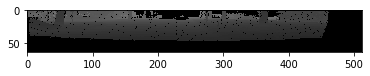

In [29]:
plot_depth(depths[0][0])

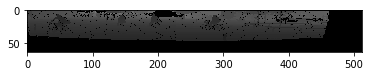

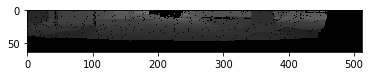

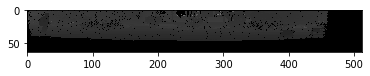

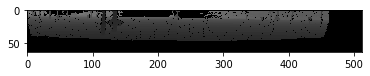

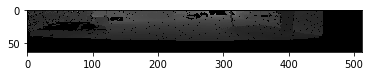

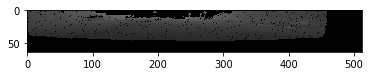

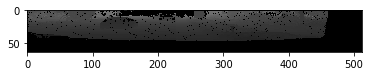

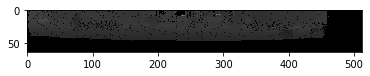

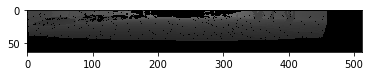

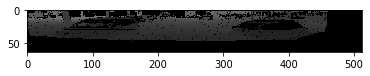

In [30]:
for d in depths:
    plot_depth(d[2])

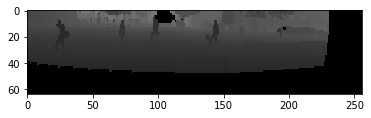

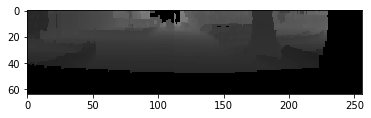

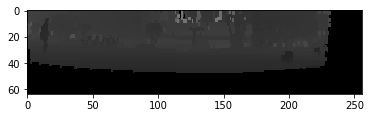

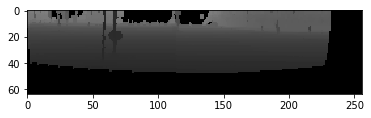

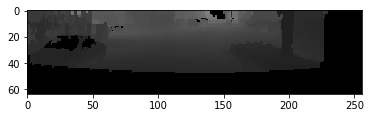

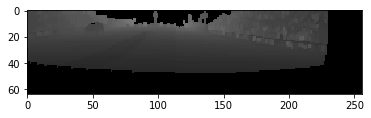

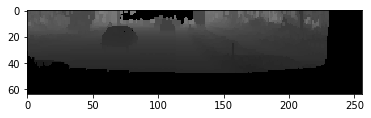

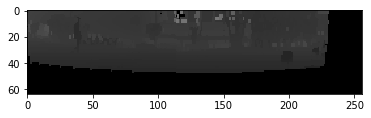

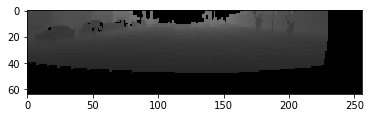

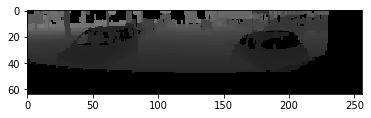

In [31]:
import torch.nn.functional as F
for d in depths:
    d_ = d
    d_small = F.max_pool2d(d_.float(), 3, padding=1, stride=(1,2)).long()
    plot_depth(d_small[2])

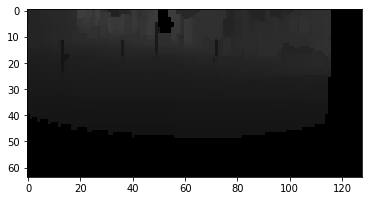

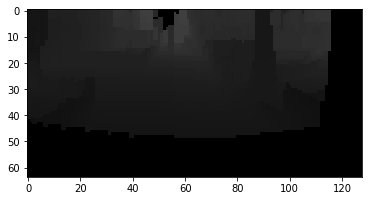

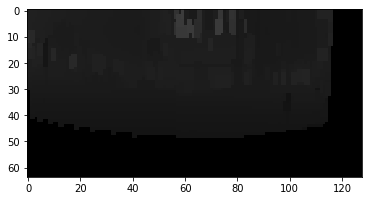

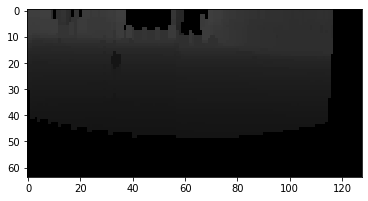

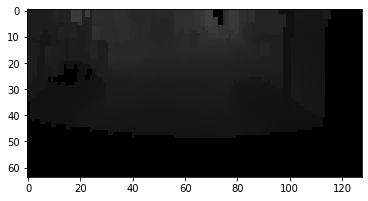

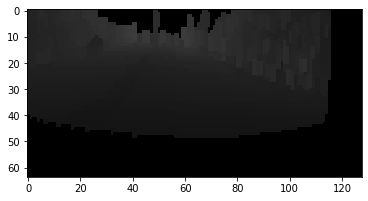

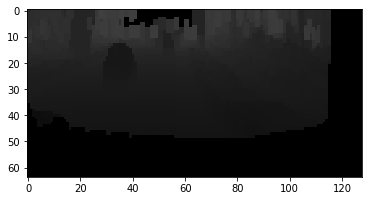

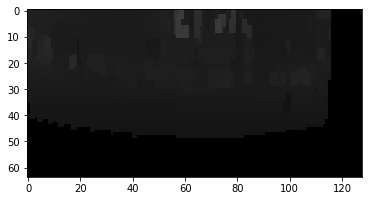

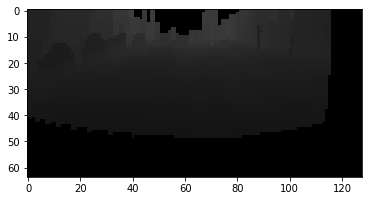

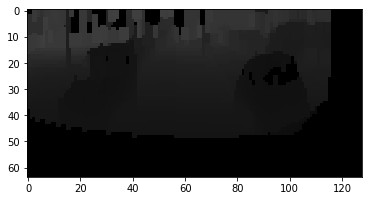

In [32]:
import torch.nn.functional as F
for d in depths:
    d_ = d
    d_small = F.max_pool2d(d_.float(), 3, padding=1, stride=(1,2)).long()
    d_small_2 = F.max_pool2d(d_small.float(), 3, padding=1, stride=(1,2)).long()
    
    plot_depth(d_small_2[2]//2)